# fim_01_03

## Code

### init

In [1]:
# import mojPck
import os
import numpy as np
import pandas as pd
import re
import io
from matplotlib import pyplot as plt
import matplotlib
import scipy
import scipy.interpolate
import scipy.integrate # scipy.integrate.cumtrapz(y, x, initial=0)
import shutil
import time


#plt.rcParams.update({'font.size': 10})
matplotlib.rcParams['axes.titlesize'] = 'large'  # fontsize of the axes title
matplotlib.rcParams['axes.labelsize'] = 'large' # fontsize of the x any y labels

PROJNM = "fim_01_03"

#### custom.js

In [2]:
%%javascript
/** Below code because this notebook is pretty large */
var rto = 120;
console.log('NB: Increase require timeout to ' + rto + ' seconds');
window.requirejs.config({waitSeconds: rto});
//alert("hi")//tester

<IPython.core.display.Javascript object>

#### custom.css

In [3]:
%%html
<style>
div.text_cell_render h1 {
    color:  #404040;
    font-size: 38pt;
}

div.text_cell_render h2 {
    color:  #696969;
    font-size: 28pt;
}
div.text_cell_render h3 {
    color: brown;
    font-size: 24pt;
}

div.text_cell_render h4 {
    color: navy;
    font-size: 16pt;
}

div.text_cell_render h5 {
    font-size: 14pt;
}

div.text_cell_render h6 {
    font-size: 14pt;
    color:  #696969;
}

div.text_cell_render h3,
div.text_cell_render h4,
div.text_cell_render h5,
div.text_cell_render h6 {
    font-weight: 300;
}


.container {width: 99% !important
            }
.rendered_html img{
    margin-left: 1px;
    display: inline-block;
}
.rendered_html table{
    margin-left: 1px;
    display: inline-block;
}

div.text_cell_render h1,
div.text_cell_render h2,
div.text_cell_render h3,
div.text_cell_render h4,
div.text_cell_render h5,
div.text_cell_render h6 {
    font-family: lato, 'HelveticaNeue-Light';
    font-weight: 500;
    padding: 0em;
}

/* remove pilcrow */
.anchor-link{
    font-size: 0;
</style>

### Tools

In [4]:
# of read
def tool_OFhist(ver="01_03", region="",  fo_name="probeTtP2", sdy="B", field = "p"):
    folder = "./"+PROJNM+"/"+PROJNM+"_"+sdy+"_"+ver+"/postProcessing/"+region+"/"+fo_name+"/"
    dirs = list_subfolders_with_paths = [f.name for f in os.scandir(folder) if f.is_dir()]
    dirs = [[d, float(d)] for d in dirs]
    dirs = sorted(dirs, key = lambda x: x[1])
    dirs = [d[0] for d in dirs]
    datas = [tool_ppData(ver=ver, region=region, time=t, fo_name=fo_name, sdy=sdy, field = field) for t in dirs]
    dfs = [pd.DataFrame(dat).set_index(0) for dat in datas]
    df = pd.concat(dfs)
    return df[~df.index.duplicated(keep='first')] # remove duplicate times


# utils
def B_odv(x, y, retx=False):
    if retx:
        return ([x, np.gradient(y,x, edge_order =2)]).T
    else:
        return np.gradient(y,x, edge_order =2)
    
#2020-02-20 09:55:49 
def sigMest(x,n=3):
    '''
    significat digits string output
    '''
    formatString = "{0:."+str(n)+"g}"
    return formatString.format(x)  


def linesInterp(df, t=[1,2,3]):
    return df.reindex(df.index.union(t)).interpolate().reindex(t)

def tool_i0(array): #index before array changes sign
    return np.where(np.diff(np.sign(array)))[0]

def tool_i0Sm(array): # tool_i0 continuous index
    i0 = tool_i0(array)
    arA = np.abs(array[i0])
    arB = np.abs(array[i0+1])
    
    return i0+(arA/(arA+arB))

def tool_root(x,y,a=0.2,b=4):
    interp_fn = scipy.interpolate.interp1d(x, y, 'quadratic', fill_value="extrapolate")
    return scipy.optimize.bisect(interp_fn, a,b)
    
def tool_fig_tiff(fig, name="exported_fig.tiff", dpi_view=120, dpi_export=600):
    import PIL
    # save figure
    # (1) save the image in memory in PNG format
    png1 = io.BytesIO()
    fig.set_dpi(dpi_export)
    fig.savefig(png1, format='png')
    fig.set_dpi(dpi_view)

    # (2) load this image into PIL
    png2 = PIL.Image.open(png1)

    # (3) save as TIFF
    png2.save(name)
    png1.close()
    
class Tool_p_hist:
    '''
    returning measured pressures
    lvl goes from 1 to 8
    P goes from 1 to 3 for P1, P2, P3
    '''
    def __init__(self):
        self.tool_p_hist = [np.genfromtxt(os.path.join('.', PROJNM, 'fim_01_01_G_00_04_00_'+str(i).zfill(2)+'.dat')) for i in range(1,9)]
    def t(self, lvl=1):
        return self.tool_p_hist[lvl-1][:,0]
    def p(self, lvl=1,P=1):
        return self.tool_p_hist[lvl-1][:,P]
    
tool_p_hist = Tool_p_hist()

def tool_ppDataAll(ver="01_03", region="",  fo_name="heatFluxBody1", sdy="B", field = "p", pos=0):
    folder = "./"+PROJNM+"/"+PROJNM+"_"+sdy+"_"+ver+"/postProcessing/"+region+"/"+fo_name+"/"
    dirs = list_subfolders_with_paths = [f.name for f in os.scandir(folder) if f.is_dir()]
    dirs = [[d, float(d)] for d in dirs]
    dirs = sorted(dirs, key = lambda x: x[1])
    dirs = [d[0] for d in dirs]
    
    datas = [tool_ppData(ver=ver, region=region, time=t, fo_name=fo_name, sdy=sdy, field = field) for t in dirs]
    srs = [pd.Series(dat[:,1+pos], index = dat[:,0]) for dat in datas]
    return pd.concat(srs)

def tool_ppData(ver="01_03", region="", time="0", fo_name="heatFluxBody1", sdy="B", field = "p"):
    data = np.genfromtxt(
        fname="./"+PROJNM+"/"+PROJNM+"_"+sdy+"_"+ver+"/postProcessing/"+region+"/"+fo_name+"/"+time+"/"+field)
    return data
    

## Export __TIFF__

#### __fim_01_03_B_04_09__

##### p(t)

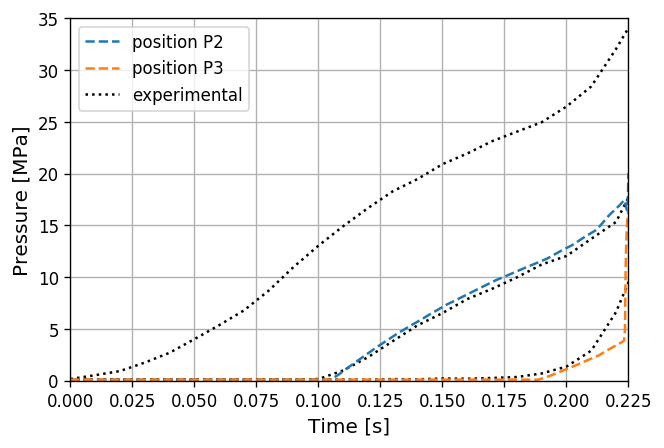

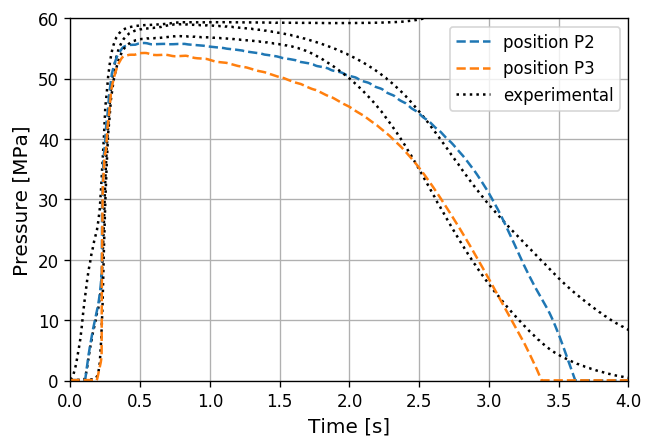

In [14]:
def lok(ver, rng=4, rngy=60, export=False): #tool_ppData_patch(ver="01_03", region="", time="0", patch="pchCav", fo_name="heatFluxBody1", sdy="C"):

    fig, ax = plt.subplots(dpi=120)
    pm = tool_p_hist

    for pos in range(3):
        ax.plot(pm.t(8),pm.p(8,pos+1)/1e6, color="black", linestyle=":")
        if pos>0:
            data = tool_ppDataAll(ver=ver, region="", fo_name="probes", sdy="B", field="p", pos=pos)
            ax.plot(data.index,data.values/1e6,
                    label="position P"+str(pos+1), linestyle="--")

    ax.plot([],[], label="experimental", color="black", linestyle=":")
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Pressure [MPa]')
    ax.grid()
    ax.legend()
    ax.set_ylim(0,rngy)
    ax.set_xlim(0,rng)
    
    if export:
        tool_fig_tiff(fig, "fim_01_03/fim_01_03_B_"+ver+"_p_"+str(rng)+"_01.tiff")
        
#     ax.set_title('Ver ('+ver+') ')
    
lok("04_09", 0.225,rngy=35, export=False)
lok("04_09", 4, export=False)

##### T(t)

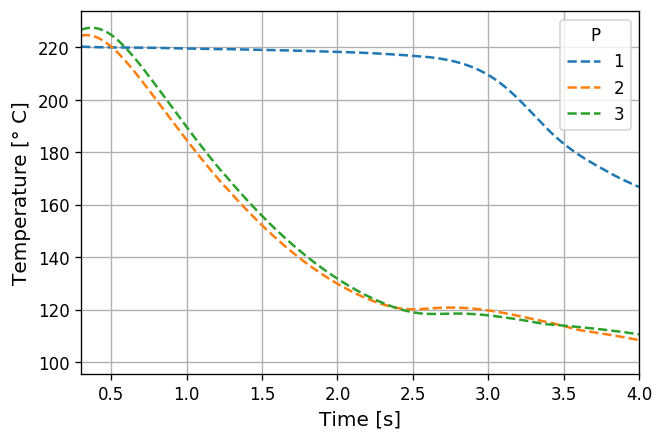

In [19]:
def lok(ver, rng=4, export=False): #tool_ppData_patch(ver="01_03", region="", time="0", patch="pchCav", fo_name="heatFluxBody1", sdy="C"):
    fig, ax = plt.subplots(dpi=120)
    pm = tool_p_hist

    for pos in range(3):
        data = tool_ppDataAll(ver=ver, region="", fo_name="probes", sdy="B", field="Tc", pos=pos)
        ax.plot(data.index,data.values,
                label=""+str(pos+1), linestyle="--")

        
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Temperature [° C]')
    ax.grid()
    ax.legend(title="P")
    #ax.set_ylim(-100,100)
    ax.set_xlim(0.3,rng)
    if export:
        tool_fig_tiff(fig, "fim_01_03/fim_01_03_B_"+ver+"_T_01.tiff")

lok("04_09", 4, export=False)

##### TT

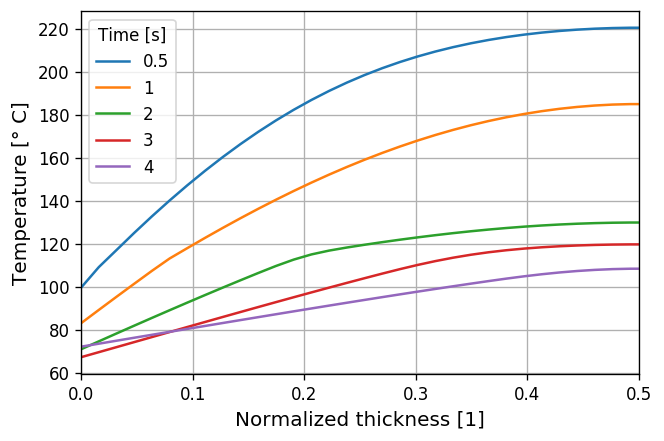

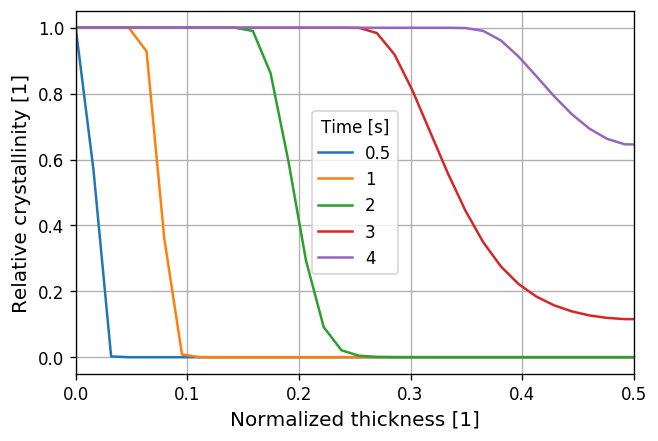

In [21]:
def lok(ver, field="Tc", absclab="", export=False): #tool_ppData_patch(ver="01_03", region="", time="0", patch="pchCav", fo_name="heatFluxBody1", sdy="C"):
    fig, ax = plt.subplots(dpi=120)
    
    times = [0.5,1,2,3,4]
    tt = linesInterp(tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = field), t=times).values
    x = np.linspace(0,1,num=len(tt[0]))
    for line,t in zip(tt,times):
        ax.plot(x, line, label=str(t))

    ax.set_xlabel('Normalized thickness [1]')
    ax.set_ylabel(absclab)
    ax.grid()
    ax.legend(title="Time [s]")
    ax.set_xlim(0,0.5)
    #ax.set_ylim(-100,100)

    #ax.set_title('Ver ('+ver+') ')
    if export:
        tool_fig_tiff(fig, "fim_01_03/fim_01_03_B_"+ver+"_tt_"+field+"_01.tiff")
    
lok(ver="04_09", field="Tc", absclab="Temperature [° C]", export=False)
lok(ver="04_09", field="zuCr", absclab="Relative crystallinity [1]", export=False)

##### TTC

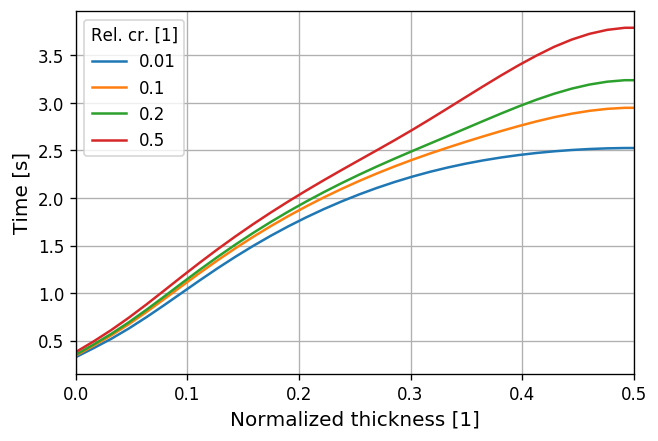

In [22]:
def lok0(ver="04_09", export=False):
    fig, ax = plt.subplots(dpi=120)
    def lok(fig, ax, ver, absclab="", crlim=0.5): #tool_ppData_patch(ver="01_03", region="", time="0", patch="pchCav", fo_name="heatFluxBody1", sdy="C"):

        tt = tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = "zuCr")
        
        y = []
        for i in range(1,65):
            timeZero = tool_root(tt.index, tt[i].values-crlim)
            y.append(timeZero)


        y = np.array(y).flatten()

        x = np.linspace(0,1,num=tt.shape[1])
        ax.plot(x, y, label = str(crlim))

        ax.set_xlabel('Normalized thickness [1]')
        ax.set_ylabel(absclab)
        ax.set_xlim(0,0.5)
        ax.legend(title="Rel. cr. [1]")
    #     ax.set_ylim(0.4,0.6)

    for crlim in [0.01, 0.1, 0.2, 0.5]:
        lok(fig, ax, ver=ver, absclab="Time [s]", crlim=crlim)
    ax.grid()
    if export:
        tool_fig_tiff(fig, "fim_01_03/fim_01_03_B_"+ver+"_ttc_"+"time"+"_01.tiff")
lok0(export=False)

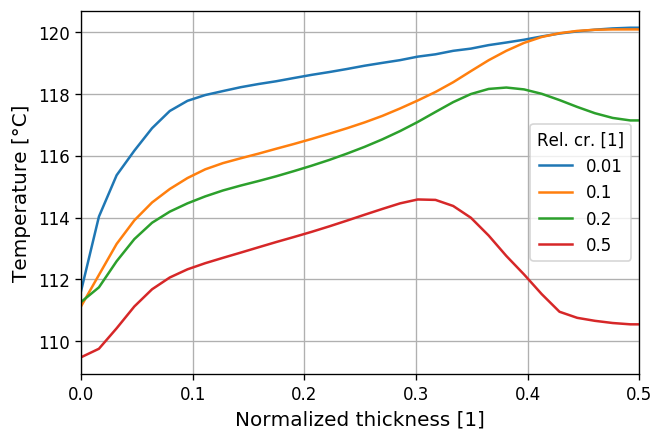

In [23]:
def lok0(ver="03_21", field="Tc", export=False):
    fig, ax = plt.subplots(dpi=120)
    def lok(fig, ax, ver, field="Tc", absclab="", crlim=0.5): #tool_ppData_patch(ver="01_03", region="", time="0", patch="pchCav", fo_name="heatFluxBody1", sdy="C"):


        times = [0.5,1,2,3,4]
        tt = tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = "zuCr")
        ttOut = tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = field)
        y = []
        for i in range(1,65):
            timeZero = tool_root(tt.index, tt[i].values-crlim)
            fun = scipy.interpolate.interp1d(tt.index, np.array(ttOut[i].values), 'quadratic')
    #         y.append(timeZero)
            y.append(fun(timeZero))


        y = np.array(y).flatten()

        x = np.linspace(0,1,num=tt.shape[1])
        ax.plot(x, y, label = str(crlim))

        ax.set_xlabel('Normalized thickness [1]')
        ax.set_ylabel(absclab)
        ax.set_xlim(0,0.5)
        ax.legend(title="Rel. cr. [1]")
    #     ax.set_ylim(0.4,0.6)

    
    for crlim in [0.01, 0.1, 0.2, 0.5]:
        lok(fig, ax, ver=ver, field=field, absclab="Temperature [°C]", crlim=crlim)
    ax.grid()
    if export:
        tool_fig_tiff(fig, "fim_01_03/fim_01_03_B_"+ver+"_ttc_"+field+"_01.tiff")
lok0(ver="04_09", field="Tc", export=False)

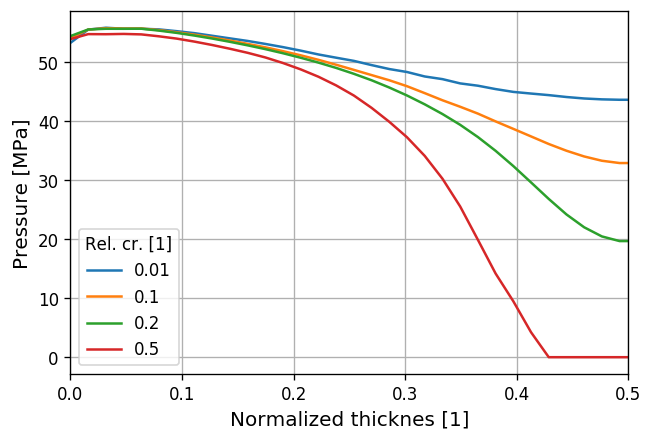

In [25]:
def lok0(ver="04_09", field="p", export=False):
    fig, ax = plt.subplots(dpi=120)
    def lok(fig, ax, ver, field="Tc", absclab="", crlim=0.5, scl=1.0): #tool_ppData_patch(ver="01_03", region="", time="0", patch="pchCav", fo_name="heatFluxBody1", sdy="C"):


        times = [0.5,1,2,3,4]
        tt = tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = "zuCr")
        ttOut = tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = field)
        y = []
        for i in range(1,65):
            timeZero = tool_root(tt.index, tt[i].values-crlim)
            fun = scipy.interpolate.interp1d(tt.index, np.array(ttOut[i].values), 'quadratic')
    #         y.append(timeZero)
            y.append(fun(timeZero))


        y = np.array(y).flatten()*scl

        x = np.linspace(0,1,num=tt.shape[1])
        ax.plot(x, y, label = str(crlim))

        ax.set_xlabel('Normalized thicknes [1]')
        ax.set_ylabel(absclab)
        ax.set_xlim(0,0.5)
        ax.legend(title="Rel. cr. [1]")
    #     ax.set_ylim(0.4,0.6)

    for crlim in [0.01, 0.1, 0.2, 0.5]:
        lok(fig, ax, ver=ver, field=field, absclab="Pressure [MPa]", crlim=crlim, scl=1e-6)
    ax.grid()
    if export:
        tool_fig_tiff(fig, "fim_01_03/fim_01_03_B_"+ver+"_ttc_"+field+"_01.tiff")
lok0(ver="04_09", field="p", export=False)

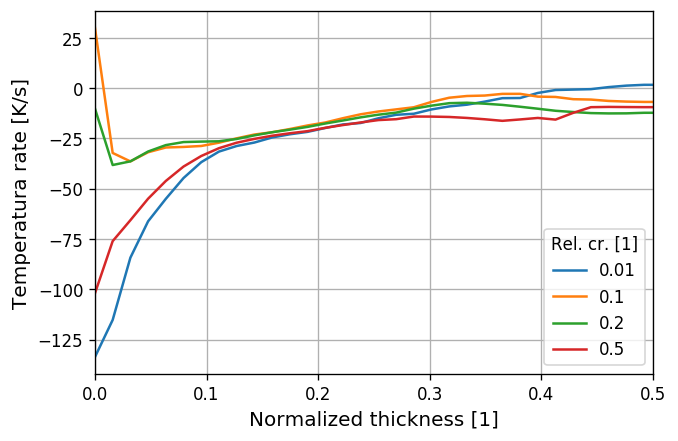

In [27]:
def lok0(ver="04_09", field="Tc", export=False):
    fig, ax = plt.subplots(dpi=120)
    def lok(fig, ax, ver, field="Tc", absclab="", crlim=0.5): #tool_ppData_patch(ver="01_03", region="", time="0", patch="pchCav", fo_name="heatFluxBody1", sdy="C"):


        times = [0.5,1,2,3,4]
        tt = tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = "zuCr")
        ttOut = tool_OFhist(ver=ver, fo_name="probeTtP2", sdy="B", field = field)
        y = []
        for i in range(1,65):
            timeZero = tool_root(tt.index, tt[i].values-crlim)
            odv = B_odv(tt.index, np.array(ttOut[i].values))
            fun = scipy.interpolate.interp1d(tt.index, odv, 'quadratic')
    #         y.append(timeZero)
            y.append(fun(timeZero))


        y = np.array(y).flatten()

        x = np.linspace(0,1,num=tt.shape[1])
        ax.plot(x, y, label = str(crlim))

        ax.set_xlabel('Normalized thickness [1]')
        ax.set_ylabel(absclab)
        ax.set_xlim(0,0.5)
        ax.legend(title="Rel. cr. [1]")
    #     ax.set_ylim(0.4,0.6)

    
    for crlim in [0.01, 0.1, 0.2, 0.5]:
        lok(fig, ax, ver=ver, field=field, absclab="Temperatura rate [K/s]", crlim=crlim)
    ax.grid()
    if export:
        tool_fig_tiff(fig, "fim_01_03/fim_01_03_B_"+ver+"_ttc_d"+field+"_01.tiff")
lok0(ver="04_09", field="Tc", export=False)

# notebook end